# Bain Family Collection Scrapbooks: AutoCropper

Need to:
1. rotate based on odd/even file-numbering
1. autocrop images
1. save as uncompressed, 8-bit TIFF tagged with AdobeRGB

In [2]:
# importing
from pathlib import Path
from subprocess import call

import cv2
import numpy as np
from ipywidgets import IntProgress, Label, VBox
from IPython.display import display
from PIL import Image

import img_qc.img_qc as img_qc

# == matplotlib options

# magic that lets us plot directly in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# parameters for matplotlib to increase our default figure size -- NOTE: figure sizes are in INCHES
plt.rcParams["figure.figsize"] = (20,20)  # set as needed for your screen and eyes

In [2]:
# functions

def rotate_bound(image, angle, center=None, scale=1.0):
    # grab the dimensions of the image and then determine the
    # center
    (height, width) = image.shape[:2]
    
    # if the center is None, initialize it as the center of
    # the image
    if center is None:
        centerX = (w // 2)
        centerY = (h // 2)
    else:
        centerX, centerY = center

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((centerX, centerY), -angle, scale)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    width_new = int((height * sin) + (width * cos))
    height_new = int((height * cos) + (width * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (width_new / 2) - centerX
    M[1, 2] += (height_new / 2) - centerY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (width_new, height_new), flags=cv2.INTER_CUBIC)

def autocrop(image_path, compression=None, dpi=400, padding=0, original_icc_profile=False, rotate_odd_even=False):
    
    # === AutoCrop

    # load the image
    image = cv2.imread(str(image_path))
                       
    # crop image inside blue tape, but don't use if not necessary
    #image = image[1200:8600, 400:5000]
    
    # rotate image CCW for odd numbered and CW for even numbered images
    if rotate_odd_even:
        if (int(image_path.stem[-1]) % 2 == 0):
            image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        else:
            image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    
    # compute the ratio of the old height to the new height
    ratio = image.shape[0] / 500.0
    
    # clone image
    image_original = image.copy()
    
    # resize image
    image = img_qc.get_resized_cv_image(image, height=500)
    
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # blur the image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # apply Otsu's automatic thresholding
    (T, thresh) = cv2.threshold(blurred, 0, 255, 
                               cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    # find the contours in the thresholded image keeping the external one
    contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    cnts = contours
    
    # sort the contours from left to right
    (cnts, bounding_boxes) = img_qc.sort_contours(cnts)
    
    # loop over the contours individually
    for (i, c) in enumerate(cnts):
        # if the contour is not sufficiently large, ignore it
        if cv2.contourArea(c) < 20000:
            continue
            
        # compute the rotated bounding box of the contour
        box = cv2.minAreaRect(c)
        box = cv2.boxPoints(box)
        box = np.int0(box)
        
        # DEBUG: draw found contour & show image
        clone = image.copy()
        cv2.drawContours(clone, [box], 0, (0, 0, 255), 2)
        plt.imshow(clone)
        
        # re-order the points in tl, tr, br, bl order
        rect = img_qc.order_points(box)
        
        # find the points and angle for minAreaRectangle
        (x, y), (w, h), theta = cv2.minAreaRect(c)
        
        # rotate image around center of minAreaRect by theta amount
        if theta < -45:
            theta = 90 + theta
        
        # DEBUG: rotate & show image
        #clone = image.copy()
        #image_rotated = img_qc.rotate(clone, theta, (x, y))
        #plt.imshow(image_rotated)
    
    # multiply the rectangle by the original ratio
    rect *= ratio
    
    # find the points we need to crop the full size original
    tl, tr, br, bl = rect
    startX = max(min(tl[0], bl[0]), 0)
    startY = max(min(tl[1], tr[1]), 0)
    endX = max(tr[0], br[0])
    endY = max(bl[1], br[1])
    
    # rotate original by theta from minAreaRect
    x *= ratio
    y *= ratio
    image_rotated = img_qc.rotate(image_original, theta, (x, y))
    
    # add padding (default hard-coded is 0 pixels)
    pixel_padding = int(padding)
    startX -= pixel_padding
    startY -= pixel_padding
    endX += pixel_padding
    endY += pixel_padding
    
    # startX/startY to max of current value and 0 to stay inside image
    startX = max(startX, 0)
    startY = max(startY, 0)
    
    # endX/endY to min of current value and max width/height of image to stay inside image
    endX = min(endX, image_rotated.shape[1])
    endY = min(endY, image_rotated.shape[0])
    
    # crop the image in memory
    image_cropped = image_rotated[int(startY):int(endY), int(startX):int(endX)]
    
    # create output directory and set output path
    output_directory_path = image_path.parents[0].joinpath('00_cropped')
    output_directory_path.mkdir(exist_ok=True)
    output_path = output_directory_path.joinpath(image_path.name)
    
    # convert to pillow Image
    image_cropped = cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB)  # convert to RGB!
    pillow_image = Image.fromarray(image_cropped)
    
    dpi = float(dpi)  # dpi MUST be a float for Pillow
        
    pillow_image.save(output_path, compression=compression, dpi=(dpi, dpi))
    
    if original_icc_profile:
        # use exiftool to copy ICC profile form original to output image
        cmd = f' exiftool -tagsfromfile {str(image_path)} -ICC_Profile -overwrite_original -q {str(output_path)}'
        call(cmd, shell=True)
        
    # DEBUG: show pillow image
    plt.imshow(pillow_image)

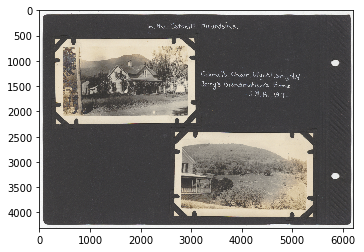

In [3]:
# batch autocrop
image_directory_path = Path('data/BainFamilyCollection_Box4/')
image_paths_list = sorted([x for x in image_directory_path.iterdir() if x.suffix == '.tif'])

# progress bar
progress_label = Label('Images Being Autocropped')
progress_bar = IntProgress(min=0, max=len(image_paths_list))
progress_widget = VBox([progress_label, progress_bar])
display(progress_widget)

for index, image_path in enumerate(image_paths_list, start=1):
    progress_label.value = image_path.name
    autocrop(image_path, dpi=600, padding=75, original_icc_profile=True, rotate_odd_even=True)
    progress_bar.value = index
